In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model, Sequence
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import plotly.express as px
import plotly.graph_objects as go

%matplotlib inline

2023-03-09 23:08:36.560678: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-09 23:08:36.560702: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
sales_df = pd.read_csv('data/sales_data_sample.csv', encoding = 'unicode_escape')
sales_df.head()

ORDERNUMBER  QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER    SALES  \
0        10107               30      95.70                2  2871.00   
1        10121               34      81.35                5  2765.90   
2        10134               41      94.74                2  3884.34   
3        10145               45      83.26                6  3746.70   
4        10159               49     100.00               14  5205.27   

         ORDERDATE   STATUS  QTR_ID  MONTH_ID  YEAR_ID  ...  \
0   2/24/2003 0:00  Shipped       1         2     2003  ...   
1    5/7/2003 0:00  Shipped       2         5     2003  ...   
2    7/1/2003 0:00  Shipped       3         7     2003  ...   
3   8/25/2003 0:00  Shipped       3         8     2003  ...   
4  10/10/2003 0:00  Shipped       4        10     2003  ...   

                    ADDRESSLINE1  ADDRESSLINE2           CITY STATE  \
0        897 Long Airport Avenue           NaN            NYC    NY   
1             59 rue de l'Abbaye           NaN          Reims   NaN   
2  27 rue du Colonel Pierre Avia           NaN          Paris   NaN   
3             78934 Hillside Dr.           NaN       Pasadena    CA   
4                7734 Strong St.           NaN  San Francisco    CA   

  POSTALCODE COUNTRY TERRITORY CONTACTLASTNAME CONTACTFIRSTNAME DEALSIZE  
0      10022     USA       NaN              Yu             Kwai    Small  
1      51100  France      EMEA         Henriot             Paul    Small  
2      75508  France      EMEA        Da Cunha           Daniel   Medium  
3      90003     USA       NaN           Young            Julie   Medium  
4        NaN     USA       NaN           Brown            Julie   Medium  

[5 rows x 25 columns]

In [3]:
sales_df.dtypes

ORDERNUMBER           int64
QUANTITYORDERED       int64
PRICEEACH           float64
ORDERLINENUMBER       int64
SALES               float64
ORDERDATE            object
STATUS               object
QTR_ID                int64
MONTH_ID              int64
YEAR_ID               int64
PRODUCTLINE          object
MSRP                  int64
PRODUCTCODE          object
CUSTOMERNAME         object
PHONE                object
ADDRESSLINE1         object
ADDRESSLINE2         object
CITY                 object
STATE                object
POSTALCODE           object
COUNTRY              object
TERRITORY            object
CONTACTLASTNAME      object
CONTACTFIRSTNAME     object
DEALSIZE             object
dtype: object

# Simple Data Cleaning 

In [4]:
from datetime import datetime
#Convert order date into date time format using Pandas
#Verify that the conversion was successful by printing out the datatype

sales_df['ORDERDATE'] = sales_df['ORDERDATE'].apply(lambda x: datetime.strptime(x,"%m/%d/%Y %H:%M"))
#sales_df['ORDERDATE'] = pd.to_datetime(sales_df['ORDERDATE']) #or you can do it using pandas to_datetime method
sales_df['ORDERDATE']

0      2003-02-24
1      2003-05-07
2      2003-07-01
3      2003-08-25
4      2003-10-10
          ...    
2818   2004-12-02
2819   2005-01-31
2820   2005-03-01
2821   2005-03-28
2822   2005-05-06
Name: ORDERDATE, Length: 2823, dtype: datetime64[ns]

In [5]:
sales_df.dtypes

ORDERNUMBER                  int64
QUANTITYORDERED              int64
PRICEEACH                  float64
ORDERLINENUMBER              int64
SALES                      float64
ORDERDATE           datetime64[ns]
STATUS                      object
QTR_ID                       int64
MONTH_ID                     int64
YEAR_ID                      int64
PRODUCTLINE                 object
MSRP                         int64
PRODUCTCODE                 object
CUSTOMERNAME                object
PHONE                       object
ADDRESSLINE1                object
ADDRESSLINE2                object
CITY                        object
STATE                       object
POSTALCODE                  object
COUNTRY                     object
TERRITORY                   object
CONTACTLASTNAME             object
CONTACTFIRSTNAME            object
DEALSIZE                    object
dtype: object

In [6]:
#- How many null elements exist in 'ADDRESSLINE2'? 
sales_df.isna().sum()

ORDERNUMBER            0
QUANTITYORDERED        0
PRICEEACH              0
ORDERLINENUMBER        0
SALES                  0
ORDERDATE              0
STATUS                 0
QTR_ID                 0
MONTH_ID               0
YEAR_ID                0
PRODUCTLINE            0
MSRP                   0
PRODUCTCODE            0
CUSTOMERNAME           0
PHONE                  0
ADDRESSLINE1           0
ADDRESSLINE2        2521
CITY                   0
STATE               1486
POSTALCODE            76
COUNTRY                0
TERRITORY           1074
CONTACTLASTNAME        0
CONTACTFIRSTNAME       0
DEALSIZE               0
dtype: int64

- since there are lot of Null values in 'addressline2', 'state', 'postal code' and 'territory' we can drop them. 
- Country would represent the order grographical information.
- Also we can drop city, address1, phone number, contact_name, contact last_name and contact first_name since they are not required for the analysis


In [7]:
df_drop  = ['ADDRESSLINE1', 'ADDRESSLINE2', 'POSTALCODE', 'CITY', 'TERRITORY', 'PHONE', 'STATE', 'CONTACTFIRSTNAME', 'CONTACTLASTNAME', 'CUSTOMERNAME', 'ORDERNUMBER']
sales_df = sales_df.drop(df_drop, axis = 1)
sales_df.head()

QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER    SALES  ORDERDATE   STATUS  \
0               30      95.70                2  2871.00 2003-02-24  Shipped   
1               34      81.35                5  2765.90 2003-05-07  Shipped   
2               41      94.74                2  3884.34 2003-07-01  Shipped   
3               45      83.26                6  3746.70 2003-08-25  Shipped   
4               49     100.00               14  5205.27 2003-10-10  Shipped   

   QTR_ID  MONTH_ID  YEAR_ID  PRODUCTLINE  MSRP PRODUCTCODE COUNTRY DEALSIZE  
0       1         2     2003  Motorcycles    95    S10_1678     USA    Small  
1       2         5     2003  Motorcycles    95    S10_1678  France    Small  
2       3         7     2003  Motorcycles    95    S10_1678  France   Medium  
3       3         8     2003  Motorcycles    95    S10_1678     USA   Medium  
4       4        10     2003  Motorcycles    95    S10_1678     USA   Medium

- How many unique values exist in the sales_df?

In [8]:
sales_df.nunique()

QUANTITYORDERED      58
PRICEEACH          1016
ORDERLINENUMBER      18
SALES              2763
ORDERDATE           252
STATUS                6
QTR_ID                4
MONTH_ID             12
YEAR_ID               3
PRODUCTLINE           7
MSRP                 80
PRODUCTCODE         109
COUNTRY              19
DEALSIZE              3
dtype: int64

# PERFORM EXPLORATORY DATA ANALYSIS AND DATA CLEANING

## visulize the count of items in a given column

In [9]:
# Function to visulize the count of items in a given column using Plotly 

def barplot_visualization(x):
    fig = plt.Figure(figsize = (12, 6))
    values = sales_df[x].value_counts().index
    value_counts = sales_df[x].value_counts()
    fig = px.bar(x = values, y = value_counts, color = sales_df[x].value_counts().index, height = 600)
    fig.show()

- Plotly is a Python graphing library that makes interactive, publication-quality graphs. 
- Check it out: https://plotly.com/python/

In [10]:
# Let's call this function for any given column such as 'COUNTRY'
barplot_visualization('COUNTRY')

In [11]:
barplot_visualization('STATUS')

- The STATUS column is very imbalanced. We drop it!

In [12]:
sales_df.drop(columns= ['STATUS'], inplace = True)
sales_df

QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER    SALES  ORDERDATE  QTR_ID  \
0                  30      95.70                2  2871.00 2003-02-24       1   
1                  34      81.35                5  2765.90 2003-05-07       2   
2                  41      94.74                2  3884.34 2003-07-01       3   
3                  45      83.26                6  3746.70 2003-08-25       3   
4                  49     100.00               14  5205.27 2003-10-10       4   
...               ...        ...              ...      ...        ...     ...   
2818               20     100.00               15  2244.40 2004-12-02       4   
2819               29     100.00                1  3978.51 2005-01-31       1   
2820               43     100.00                4  5417.57 2005-03-01       1   
2821               34      62.24                1  2116.16 2005-03-28       1   
2822               47      65.52                9  3079.44 2005-05-06       2   

      MONTH_ID  YEAR_ID  PRODUCTLINE  MSRP PRODUCTCODE  COUNTRY DEALSIZE  
0            2     2003  Motorcycles    95    S10_1678      USA    Small  
1            5     2003  Motorcycles    95    S10_1678   France    Small  
2            7     2003  Motorcycles    95    S10_1678   France   Medium  
3            8     2003  Motorcycles    95    S10_1678      USA   Medium  
4           10     2003  Motorcycles    95    S10_1678      USA   Medium  
...        ...      ...          ...   ...         ...      ...      ...  
2818        12     2004        Ships    54    S72_3212    Spain    Small  
2819         1     2005        Ships    54    S72_3212  Finland   Medium  
2820         3     2005        Ships    54    S72_3212    Spain   Medium  
2821         3     2005        Ships    54    S72_3212   France    Small  
2822         5     2005        Ships    54    S72_3212      USA   Medium  

[2823 rows x 13 columns]

In [13]:
barplot_visualization('PRODUCTLINE')

In [14]:
barplot_visualization('DEALSIZE')

## Perform One Hot Encoding on Categorical Variables

In [15]:
# Function to add dummy variables to replace categorical variables
# That is, perform One Hot Encoding

def dummies(x):
    dummy = pd.get_dummies(sales_df[x])
    sales_df.drop(columns = x , inplace = True)
    return pd.concat([sales_df, dummy], axis = 1)

In [16]:
# Let's obtain dummy variables for the column 'COUNTRY'
sales_df = dummies('COUNTRY')
sales_df.head()

QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER    SALES  ORDERDATE  QTR_ID  \
0               30      95.70                2  2871.00 2003-02-24       1   
1               34      81.35                5  2765.90 2003-05-07       2   
2               41      94.74                2  3884.34 2003-07-01       3   
3               45      83.26                6  3746.70 2003-08-25       3   
4               49     100.00               14  5205.27 2003-10-10       4   

   MONTH_ID  YEAR_ID  PRODUCTLINE  MSRP  ... Italy Japan  Norway  Philippines  \
0         2     2003  Motorcycles    95  ...     0     0       0            0   
1         5     2003  Motorcycles    95  ...     0     0       0            0   
2         7     2003  Motorcycles    95  ...     0     0       0            0   
3         8     2003  Motorcycles    95  ...     0     0       0            0   
4        10     2003  Motorcycles    95  ...     0     0       0            0   

   Singapore  Spain  Sweden  Switzerland  UK  USA  
0          0      0       0            0   0    1  
1          0      0       0            0   0    0  
2          0      0       0            0   0    0  
3          0      0       0            0   0    1  
4          0      0       0            0   0    1  

[5 rows x 31 columns]

In [17]:
# Let's obtain dummy variables for the column 'COUNTRY'
sales_df = dummies('PRODUCTLINE')
sales_df.head()

QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER    SALES  ORDERDATE  QTR_ID  \
0               30      95.70                2  2871.00 2003-02-24       1   
1               34      81.35                5  2765.90 2003-05-07       2   
2               41      94.74                2  3884.34 2003-07-01       3   
3               45      83.26                6  3746.70 2003-08-25       3   
4               49     100.00               14  5205.27 2003-10-10       4   

   MONTH_ID  YEAR_ID  MSRP PRODUCTCODE  ... Switzerland  UK  USA  \
0         2     2003    95    S10_1678  ...           0   0    1   
1         5     2003    95    S10_1678  ...           0   0    0   
2         7     2003    95    S10_1678  ...           0   0    0   
3         8     2003    95    S10_1678  ...           0   0    1   
4        10     2003    95    S10_1678  ...           0   0    1   

   Classic Cars  Motorcycles  Planes  Ships  Trains  Trucks and Buses  \
0             0            1       0      0       0                 0   
1             0            1       0      0       0                 0   
2             0            1       0      0       0                 0   
3             0            1       0      0       0                 0   
4             0            1       0      0       0                 0   

   Vintage Cars  
0             0  
1             0  
2             0  
3             0  
4             0  

[5 rows x 37 columns]

In [18]:
# Let's obtain dummy variables for the column 'COUNTRY'
sales_df = dummies('DEALSIZE')
sales_df.head()

QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER    SALES  ORDERDATE  QTR_ID  \
0               30      95.70                2  2871.00 2003-02-24       1   
1               34      81.35                5  2765.90 2003-05-07       2   
2               41      94.74                2  3884.34 2003-07-01       3   
3               45      83.26                6  3746.70 2003-08-25       3   
4               49     100.00               14  5205.27 2003-10-10       4   

   MONTH_ID  YEAR_ID  MSRP PRODUCTCODE  ...  Classic Cars  Motorcycles  \
0         2     2003    95    S10_1678  ...             0            1   
1         5     2003    95    S10_1678  ...             0            1   
2         7     2003    95    S10_1678  ...             0            1   
3         8     2003    95    S10_1678  ...             0            1   
4        10     2003    95    S10_1678  ...             0            1   

   Planes  Ships  Trains  Trucks and Buses  Vintage Cars  Large  Medium  Small  
0       0      0       0                 0             0      0       0      1  
1       0      0       0                 0             0      0       0      1  
2       0      0       0                 0             0      0       1      0  
3       0      0       0                 0             0      0       1      0  
4       0      0       0                 0             0      0       1      0  

[5 rows x 39 columns]

In [19]:
# Since the number unique product code is 109, if we add one-hot variables, there 
# would be additional 109 columns, we can avoid that by using categorical encoding
# This is not the optimal way of dealing with it but it's important to avoid curse of dimensionality
sales_df['PRODUCTCODE'] = pd.Categorical(sales_df['PRODUCTCODE']).codes
sales_df.head()

QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER    SALES  ORDERDATE  QTR_ID  \
0               30      95.70                2  2871.00 2003-02-24       1   
1               34      81.35                5  2765.90 2003-05-07       2   
2               41      94.74                2  3884.34 2003-07-01       3   
3               45      83.26                6  3746.70 2003-08-25       3   
4               49     100.00               14  5205.27 2003-10-10       4   

   MONTH_ID  YEAR_ID  MSRP  PRODUCTCODE  ...  Classic Cars  Motorcycles  \
0         2     2003    95            0  ...             0            1   
1         5     2003    95            0  ...             0            1   
2         7     2003    95            0  ...             0            1   
3         8     2003    95            0  ...             0            1   
4        10     2003    95            0  ...             0            1   

   Planes  Ships  Trains  Trucks and Buses  Vintage Cars  Large  Medium  Small  
0       0      0       0                 0             0      0       0      1  
1       0      0       0                 0             0      0       0      1  
2       0      0       0                 0             0      0       1      0  
3       0      0       0                 0             0      0       1      0  
4       0      0       0                 0             0      0       1      0  

[5 rows x 39 columns]

## Group data by Order date for further analysis

In [20]:
# Group data by order date
sales_df_group = sales_df.groupby(by = "ORDERDATE").sum()
sales_df_group

QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER     SALES  QTR_ID  \
ORDERDATE                                                                   
2003-01-06              151     288.78               10  12133.25       4   
2003-01-09              142     284.96               10  11432.34       4   
2003-01-10               80     150.14                3   6864.05       2   
2003-01-29              541    1417.54              136  54702.00      16   
2003-01-31              443    1061.89               91  44621.96      13   
...                     ...        ...              ...       ...     ...   
2005-05-13              259     561.18               21  31821.90      12   
2005-05-17              509    1269.43              105  59475.10      28   
2005-05-29              607    1148.40               94  51233.18      30   
2005-05-30              187     542.16               18  14578.75      14   
2005-05-31              696    1561.40              112  78918.03      38   

            MONTH_ID  YEAR_ID  MSRP  PRODUCTCODE  Australia  ...  \
ORDERDATE                                                    ...   
2003-01-06         4     8012   363        174.0          0  ...   
2003-01-09         4     8012   372        181.0          0  ...   
2003-01-10         2     4006   155         37.0          0  ...   
2003-01-29        16    32048  1695        723.0          0  ...   
2003-01-31        13    26039  1365        720.0          0  ...   
...              ...      ...   ...          ...        ...  ...   
2005-05-13        30    12030   728        101.0          0  ...   
2005-05-17        70    28070  1669        462.0          0  ...   
2005-05-29        75    30075  1328        797.0         13  ...   
2005-05-30        35    14035   618        265.0          0  ...   
2005-05-31        95    38095  2065        899.0          0  ...   

            Classic Cars  Motorcycles  Planes  Ships  Trains  \
ORDERDATE                                                      
2003-01-06             0            0       0      0       0   
2003-01-09             0            0       0      0       0   
2003-01-10             0            0       0      0       0   
2003-01-29             3            0       0      0       0   
2003-01-31             7            0       0      0       2   
...                  ...          ...     ...    ...     ...   
2005-05-13             0            6       0      0       0   
2005-05-17            14            0       0      0       0   
2005-05-29             7            0       0      0       0   
2005-05-30             0            0       0      0       0   
2005-05-31             7            0       0      0       0   

            Trucks and Buses  Vintage Cars  Large  Medium  Small  
ORDERDATE                                                         
2003-01-06                 0             4      0       2      2  
2003-01-09                 0             4      0       2      2  
2003-01-10                 0             2      0       1      1  
2003-01-29                 7             6      0      10      6  
2003-01-31                 4             0      0       8      5  
...                      ...           ...    ...     ...    ...  
2005-05-13                 0             0      2       3      1  
2005-05-17                 0             0      2       8      4  
2005-05-29                 0             8      0       8      7  
2005-05-30                 0             7      0       1      6  
2005-05-31                11             1      3       9      7  

[252 rows x 38 columns]

In [21]:
fig = px.bar(x = sales_df_group.index, y = sales_df_group.SALES, title ='Month Sales')
fig.show()

- Sales Peaked on 24th November, 2004 at about 137.6k

In [22]:
# We can drop 'ORDERDATE' and keep the rest of the date-related data such as 'MONTH'
sales_df.drop("ORDERDATE", axis = 1, inplace = True)
sales_df.shape

(2823, 38)

## Calculating Correlation Matrix between variables

In [23]:
#Plot the correlation matrix between variables
#Comment on the matrix results.
corr=sales_df.iloc[:,:10].corr()
fig = px.imshow(corr, text_auto=True, aspect="auto")
fig.show()

- QTR_ID and MONTH_ID are very highly correlated(), we'll therefore drop one of these columns.

In [24]:
# Let's drop 'QTR_ID' (or 'MONTH_ID') 
sales_df.drop("QTR_ID", axis = 1, inplace = True)
sales_df.shape

(2823, 37)

## Let's plot distplots
- Distplot shows the (1) histogram, (2) kde plot and (3) rug plot.
    1. Histogram: it's a graphical display of data using bars with various heights. Each bar groups numbers into ranges and taller bars show that more data falls in that range.
    2. Kde Plot: Kernel Density Estimate is used for visualizing the Probability Density of a continuous variable.
    3. Rug plot: plot of data for a single quantitative variable, displayed as marks along an axis (one-dimensional scatter plot). 


In [25]:
import plotly.figure_factory as ff

plt.figure(figsize = (10, 10))

for i in range(8):
    if sales_df.columns[i] != 'ORDERLINENUMBER':
        fig = ff.create_distplot([sales_df[sales_df.columns[i]].apply(lambda x: float(x))], ['distplot'])
        fig.update_layout(title_text = sales_df.columns[i])
        fig.show()

<Figure size 720x720 with 0 Axes>

## Visualize the relationship between variables using pairplots

In [26]:
# Visualize the relationship between variables using pairplots
plt.figure(figsize = (15, 15))

fig = px.scatter_matrix(sales_df,
    dimensions = sales_df.columns[:8], color = 'MONTH_ID')

fig.update_layout(
    title = 'Sales Data',
    width = 1100,
    height = 1100,
)
fig.show()


<Figure size 1080x1080 with 0 Axes>

- A trend exists between 'SALES' and 'QUANTITYORDERED'  
- A trend exists between 'MSRP' and 'PRICEEACH'  
- A trend exists between 'PRICEEACH' and 'SALES'
- It seems that sales growth exists as we move from 2013 to 2014 to 2015 ('SALES' vs. 'YEAR_ID')
- zoom in into 'SALES' and 'QUANTITYORDERED', you will be able to see the monthly information color coded on the graph


# APPLY MARKET SEGMENTATION
## Find the optimal number of clusters using the Elbow Method

- The elbow method is a heuristic method of interpretation and validation of consistency within cluster analysis designed to help find the appropriate number of clusters in a dataset.
- If the line chart looks like an arm, then the "elbow" on the arm is the value of k that is the best.

In [27]:
# Scale the data
scaler = StandardScaler()
sales_df_scaled = scaler.fit_transform(sales_df)
sales_df_scaled.shape

(2823, 37)

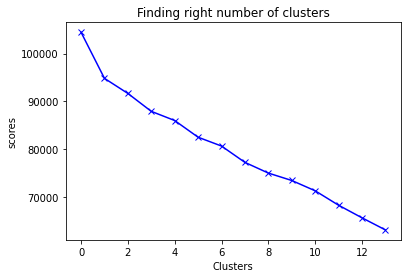

In [28]:
def get_scores_from_elbow_method(df, n):
    range_values = range(1, n)
    scores = []
    for i in range_values:
        kmeans = KMeans(n_clusters = i)
        kmeans.fit(df)
        scores.append(kmeans.inertia_) # intertia is the Sum of squared distances of samples to their closest cluster center
    
    return scores

scores = get_scores_from_elbow_method(sales_df_scaled, 15)
plt.plot(scores, 'bx-')
plt.title('Finding right number of clusters')
plt.xlabel('Clusters')
plt.ylabel('scores') 
plt.show()

- Kmeans details in Sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
- From this we can observe that, elbow of the curve is not easy to observe
- Note that curve will change everytime we run the cell

## Apply K-means Clustering method

In [29]:
# Cluster the data using k-means, Ill use five for now before we apply an auto encoder.
kmeans = KMeans(5)
kmeans.fit(sales_df_scaled)
labels = kmeans.labels_
labels

array([1, 1, 4, ..., 2, 2, 2], dtype=int32)

In [30]:
# Let's take a look at the cluster centers 
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_centers = pd.DataFrame(data = cluster_centers, columns = [sales_df.columns])
cluster_centers

QUANTITYORDERED  PRICEEACH ORDERLINENUMBER        SALES  MONTH_ID  \
0       47.222930  99.799554        5.369427  8293.753248  6.770701   
1       30.366308  68.671097        6.695397  2039.502174  7.196866   
2       34.730769  83.855470        6.799145  3053.150128  6.931624   
3       35.692308  80.471818        6.342657  3322.323217  6.416084   
4       37.612444  95.777093        6.373333  4429.827822  7.248000   

       YEAR_ID        MSRP PRODUCTCODE     Australia       Austria  ...  \
0  2003.910828  158.184713   26.242038  4.458599e-02  2.547771e-02  ...   
1  2003.791381   76.805093   59.566112  8.814887e-02  1.762977e-02  ...   
2  2003.816239   86.128205   89.337607  8.547009e-03  1.709402e-02  ...   
3  2003.961538   95.055944   56.996503  2.775558e-17  1.040834e-17  ...   
4  2003.785778  118.868444   44.141333  7.644444e-02  2.577778e-02  ...   

   Classic Cars   Motorcycles        Planes         Ships        Trains  \
0  6.178344e-01  1.210191e-01  5.732484e-02 -4.163336e-17  6.369427e-03   
1  2.830558e-01  1.459354e-01  1.508325e-01  1.387779e-17  4.211557e-02   
2 -1.110223e-16  8.326673e-17 -9.714451e-17  1.000000e+00  6.938894e-18   
3  3.916084e-01  5.944056e-02  1.048951e-01 -2.775558e-17  4.895105e-02   
4  4.168889e-01  1.297778e-01  1.004444e-01  1.249001e-16  1.688889e-02   

  Trucks and Buses  Vintage Cars         Large        Medium     Small  
0     4.458599e-02  1.528662e-01  1.000000e+00 -2.220446e-16  0.000000  
1     9.892262e-02  2.791381e-01 -1.179612e-16 -7.771561e-16  1.000000  
2    -4.163336e-17  2.498002e-16 -6.938894e-18  4.572650e-01  0.542735  
3     1.468531e-01  2.482517e-01  6.938894e-17  5.384615e-01  0.461538  
4     1.342222e-01  2.017778e-01 -9.714451e-17  9.982222e-01  0.001778  

[5 rows x 37 columns]

- Cluster 0 (Highest) - This group represents customers who buy items in high quantity centered around ~47, they buy items in all price range leaning towards high price items of ~99. They also correspond to the highest total sales around ~8296 and they are active throughout the year. They are the highest buyers of products with high MSRP ~158.
- Cluster 1 - This group represents customers who buy items in varying quantity ~35, they tend to buy high price items ~96. Their sales is bit better average ~4435, they buy products with second highest MSRP of ~133.
- Cluster 2 (lowest) - This group represents customers who buy items in low quantity ~30. They tend to buy low price items ~68. Their sales ~2044 is lower than other clusters and they are extremely active around holiday season. They buy products with low MSRP ~75.
- Cluster 3 - This group represents customers who are only active during the holidays. they buy in lower quantity ~35, but they tend to buy average price items around ~86. They also correspond to lower total sales around ~3673, they tend to buy items with MSRP around 102.
- Cluster 4 - This group represents customers who buy items in varying quantity ~39, they tend to buy average price items ~94. Their sales ~4280.

In [31]:
y_kmeans = kmeans.fit_predict(sales_df_scaled)
y_kmeans, y_kmeans.shape

(array([3, 3, 1, ..., 4, 4, 4], dtype=int32), (2823,))

In [32]:
# Add a label (which cluster) corresponding to each data point
sale_df_cluster = pd.concat([sales_df, pd.DataFrame({'cluster':labels})], axis = 1)
sale_df_cluster

QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER    SALES  MONTH_ID  YEAR_ID  \
0                  30      95.70                2  2871.00         2     2003   
1                  34      81.35                5  2765.90         5     2003   
2                  41      94.74                2  3884.34         7     2003   
3                  45      83.26                6  3746.70         8     2003   
4                  49     100.00               14  5205.27        10     2003   
...               ...        ...              ...      ...       ...      ...   
2818               20     100.00               15  2244.40        12     2004   
2819               29     100.00                1  3978.51         1     2005   
2820               43     100.00                4  5417.57         3     2005   
2821               34      62.24                1  2116.16         3     2005   
2822               47      65.52                9  3079.44         5     2005   

      MSRP  PRODUCTCODE  Australia  Austria  ...  Motorcycles  Planes  Ships  \
0       95            0          0        0  ...            1       0      0   
1       95            0          0        0  ...            1       0      0   
2       95            0          0        0  ...            1       0      0   
3       95            0          0        0  ...            1       0      0   
4       95            0          0        0  ...            1       0      0   
...    ...          ...        ...      ...  ...          ...     ...    ...   
2818    54          108          0        0  ...            0       0      1   
2819    54          108          0        0  ...            0       0      1   
2820    54          108          0        0  ...            0       0      1   
2821    54          108          0        0  ...            0       0      1   
2822    54          108          0        0  ...            0       0      1   

      Trains  Trucks and Buses  Vintage Cars  Large  Medium  Small  cluster  
0          0                 0             0      0       0      1        1  
1          0                 0             0      0       0      1        1  
2          0                 0             0      0       1      0        4  
3          0                 0             0      0       1      0        4  
4          0                 0             0      0       1      0        4  
...      ...               ...           ...    ...     ...    ...      ...  
2818       0                 0             0      0       0      1        2  
2819       0                 0             0      0       1      0        2  
2820       0                 0             0      0       1      0        2  
2821       0                 0             0      0       0      1        2  
2822       0                 0             0      0       1      0        2  

[2823 rows x 38 columns]

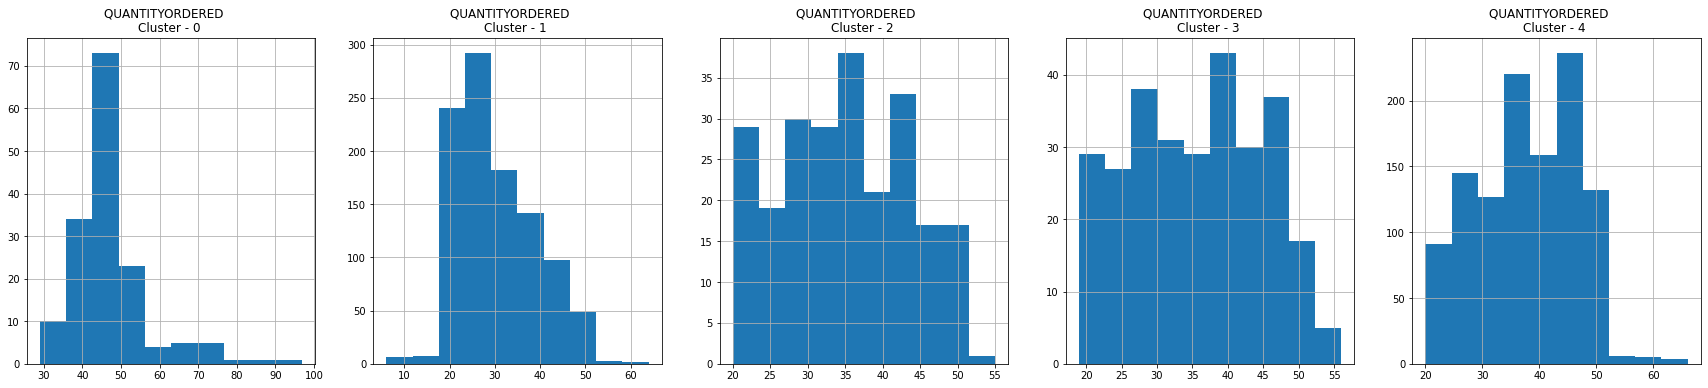

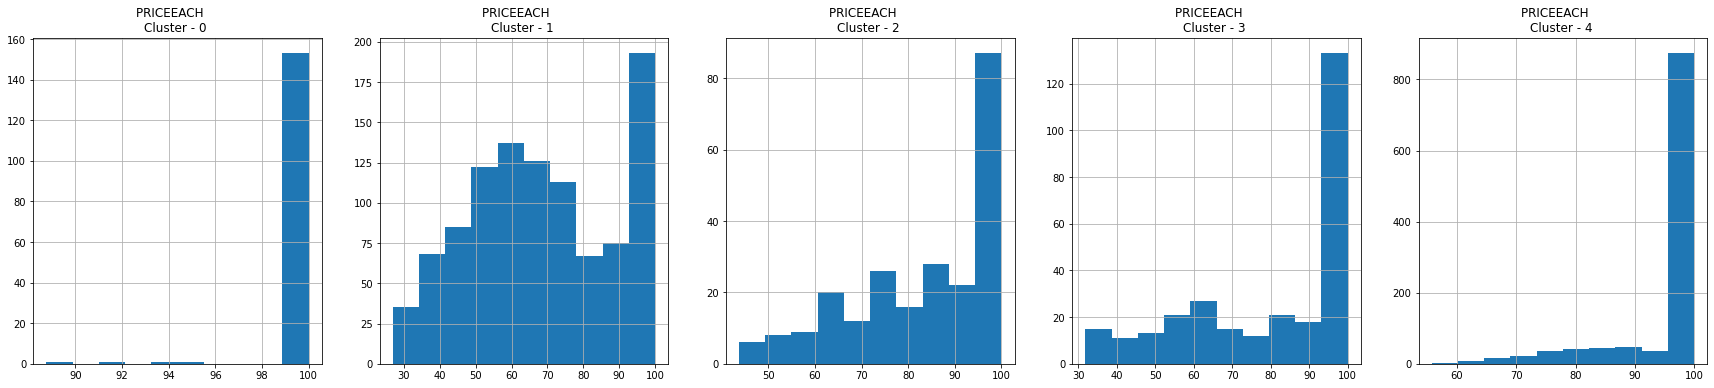

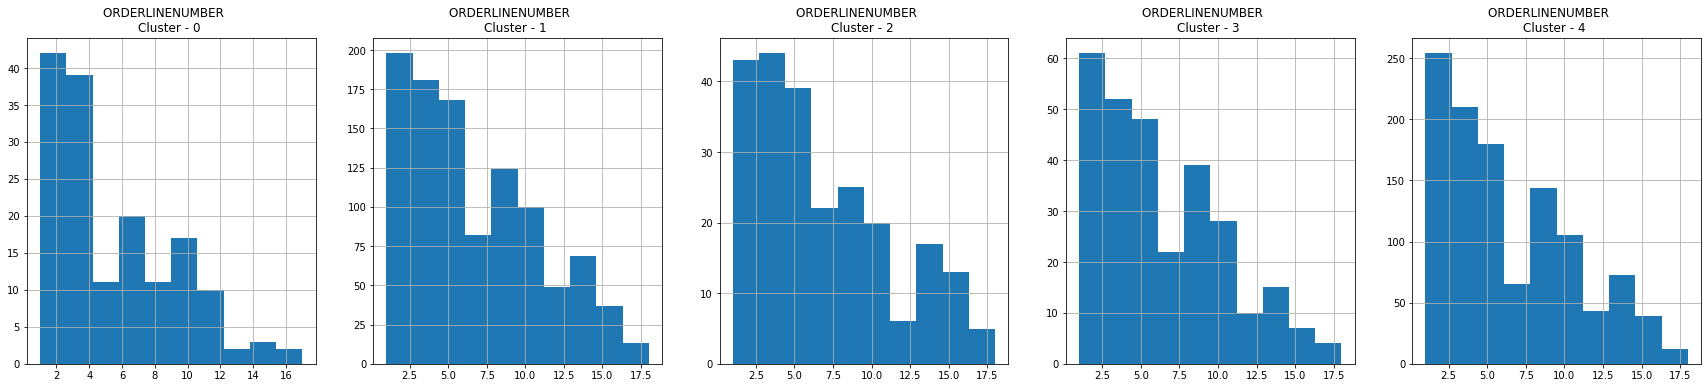

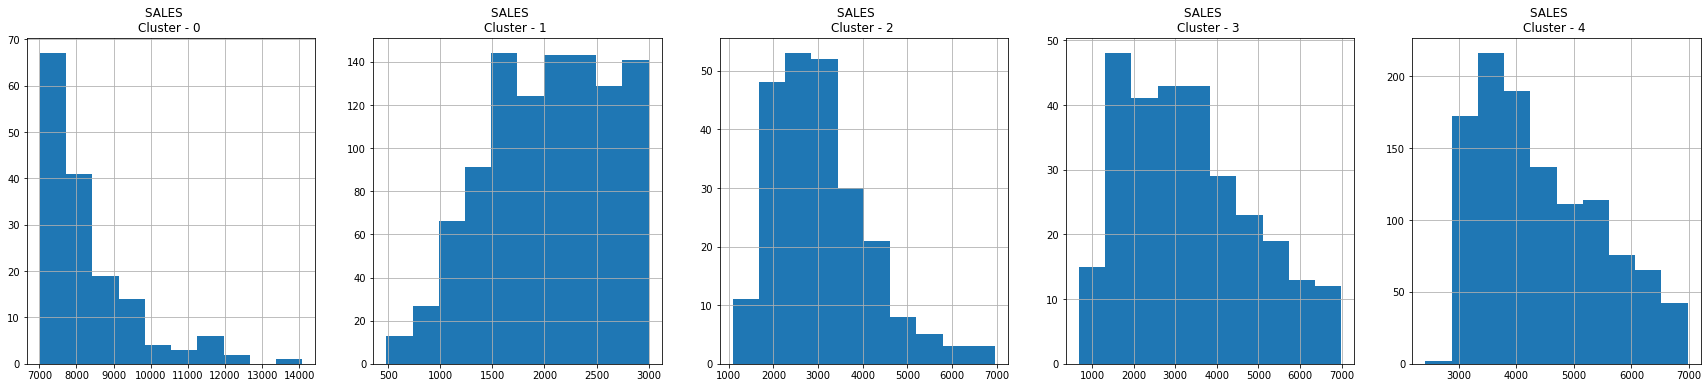

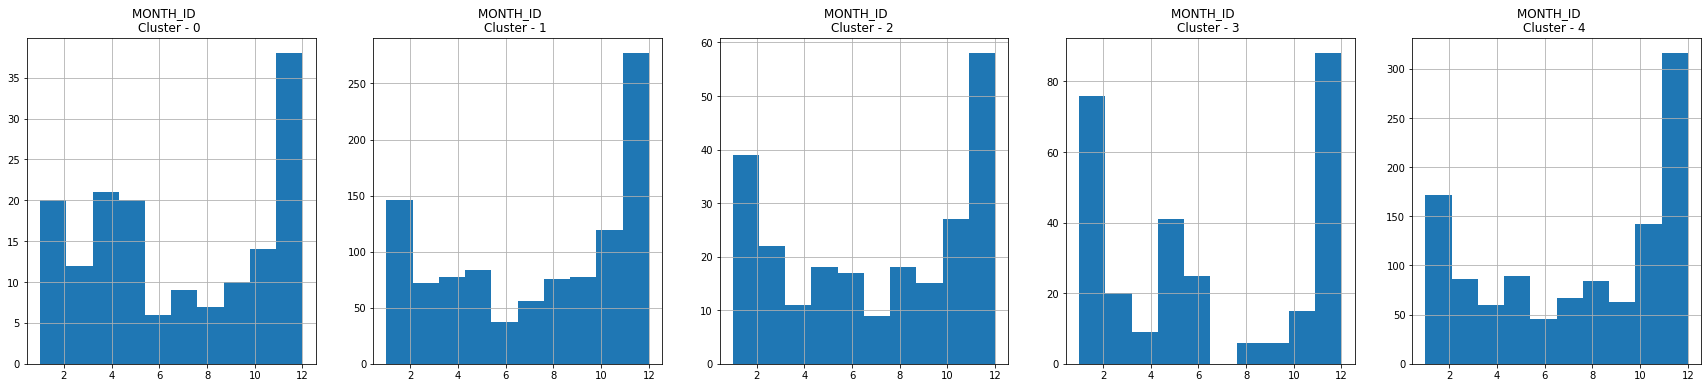

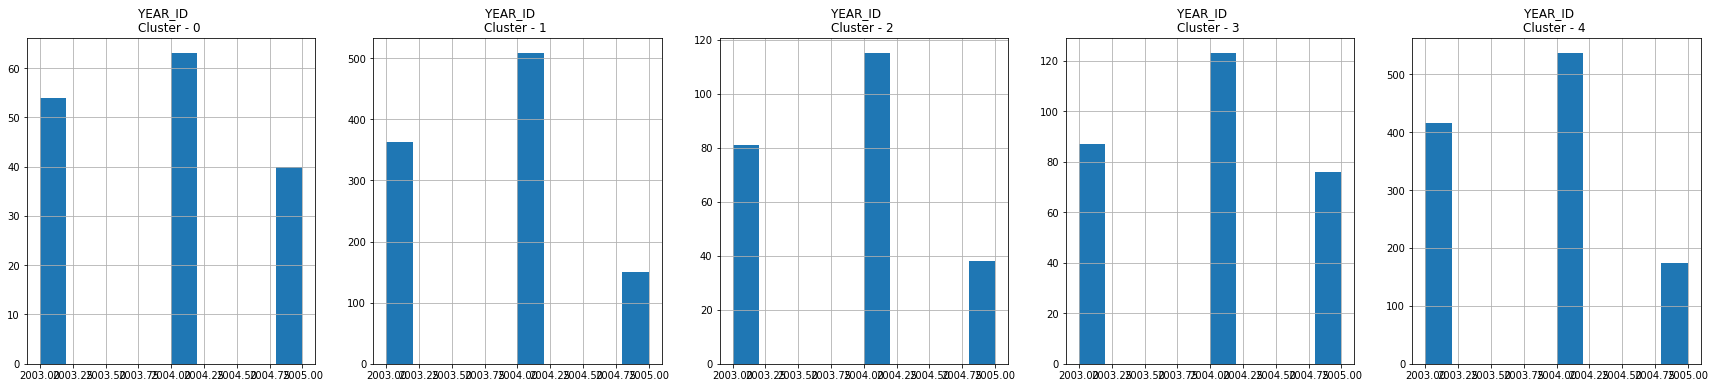

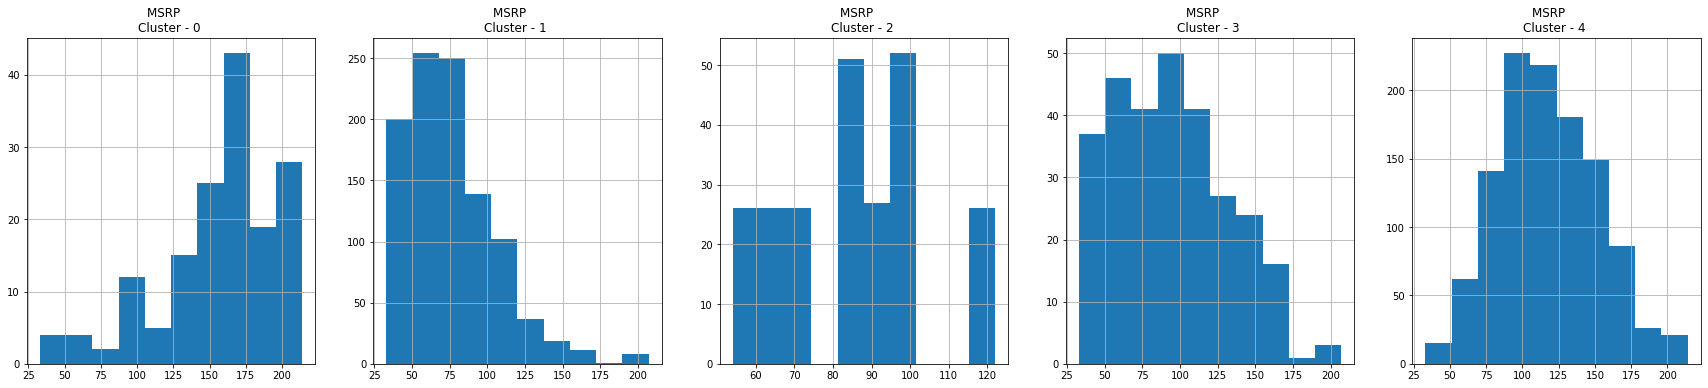

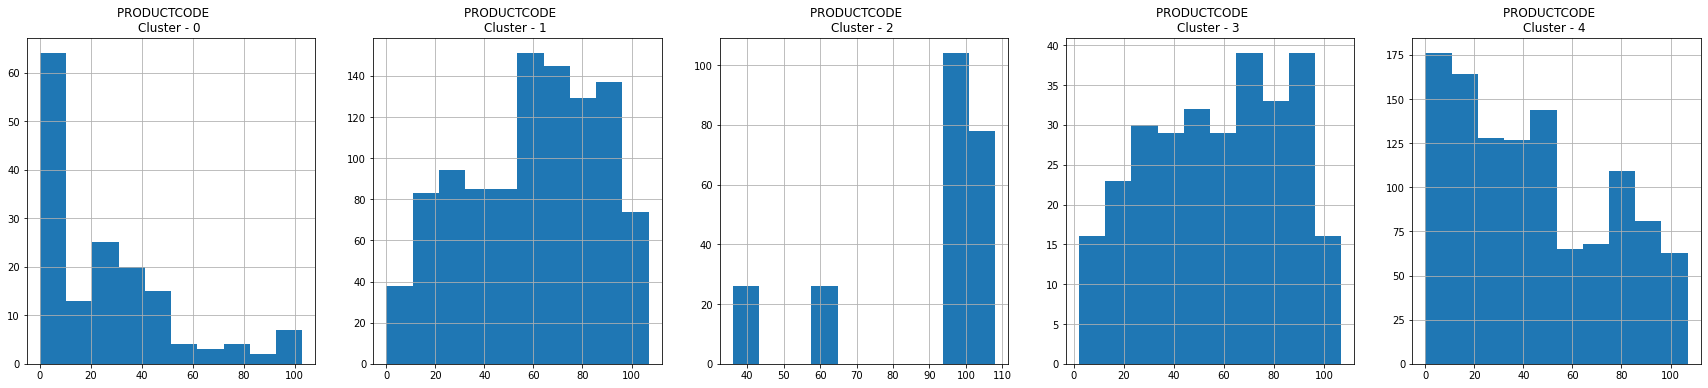

In [33]:
sales_df['ORDERLINENUMBER'] = sales_df['ORDERLINENUMBER'].apply(lambda x: float(x))

# plot histogram for each feature based on cluster 
def plot_hist_4_clusters(df,n):
    for i in sales_df.columns[:8]:
        plt.figure(figsize = (30, 6))
        for j in range(n):
            plt.subplot(1, n, j+1)
            cluster = df[df['cluster'] == j]
            cluster[i].hist()
            plt.title('{}    \nCluster - {} '.format(i,j))

        plt.show()
        
plot_hist_4_clusters(sale_df_cluster, 5)

## Apply Principle Component Analysis and Visualize the Results 

In [34]:
# Reduce the original data to 3 dimensions using PCA for visualizig the clusters
pca = PCA(n_components = 3)
principal_comp = pca.fit_transform(sales_df_scaled)
pca_df = pd.DataFrame(data = principal_comp, columns = ['pca1', 'pca2', 'pca3'])
pca_df.head()

pca1      pca2      pca3
0 -0.486329 -1.200389  1.010254
1 -0.784695 -1.050090  1.442027
2  1.431387  0.113597  0.309733
3  1.288399 -0.207295 -0.585443
4  1.976042 -0.131134 -1.088189

In [35]:
# Concatenate the clusters labels to the dataframe
pca_df = pd.concat([pca_df, pd.DataFrame({'cluster':labels})], axis = 1)
pca_df

pca1      pca2      pca3  cluster
0    -0.486329 -1.200389  1.010254        1
1    -0.784695 -1.050090  1.442027        1
2     1.431387  0.113597  0.309733        4
3     1.288399 -0.207295 -0.585443        4
4     1.976042 -0.131134 -1.088189        4
...        ...       ...       ...      ...
2818 -2.450266  1.085104 -1.558142        2
2819 -0.158176  3.688144  0.635622        2
2820  0.389796  4.123019 -0.076381        2
2821 -2.788933  2.381570  1.558565        2
2822 -0.705508  3.335746 -0.559699        2

[2823 rows x 4 columns]

In [36]:
# Visualize clusters using 3D-Scatterplot
fig = px.scatter_3d(pca_df, x = 'pca1', y = 'pca2', z = 'pca3', 
              color = 'cluster', symbol = 'cluster', size_max = 18, opacity = 0.7)
legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="left",
    x=0
)
fig.update_layout(margin = dict(l = 0, r = 0, b = 0, t = 0),legend=legend)

In [37]:
#Change the number of components to 2, modify the code and rerun the model
#Visualize the clusters using 2D plots
# Reduce the original data to 3 dimensions using PCA for visualizig the clusters
pca_t = PCA(n_components = 2)
principal_comp_t = pca_t.fit_transform(sales_df_scaled)
pca_df_t = pd.DataFrame(data = principal_comp_t, columns = ['pca1', 'pca2'])

# Concatenate the clusters labels to the dataframe
pca_df_t = pd.concat([pca_df_t, pd.DataFrame({'cluster':labels})], axis = 1)

# Visualize clusters using 3D-Scatterplot
fig = px.scatter(pca_df_t, x = 'pca1', y = 'pca2', 
              color = 'cluster', symbol = 'cluster', size_max = 18, opacity = 0.7)

fig.update_layout(margin = dict(l = 0, r = 0, b = 0, t = 0),legend=legend)

## Apply an Autoencoder
### Perform Dimensionality Reduction using the Autoencoder

In [38]:
class DataGenerator(Sequence):
    def __init__(self, df, batch_size=32, shuffle=True):
        self.df = df
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(df))
        self.on_epoch_end()

    def __len__(self):
        return len(self.df) // self.batch_size

    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        X = scaler.fit_transform(self.df.iloc[indices])
        y = scaler.fit_transform(self.df.iloc[indices])
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

In [39]:
train_data = sales_df.sample(frac=0.8, random_state=42)

val_data = sales_df.drop(train_data.index)

train_generator = DataGenerator(train_data)
val_generator = DataGenerator(val_data)

#### Auto-encoder Model

In [40]:
# from keras.optimizers import SGD

# Glorot Uniform initializer: https://keras.rstudio.com/reference/initializer_glorot_uniform.html

encoding_dim = 10  #10 floats

input_df = Input(shape = (37,))
x = Dense(50, activation = 'relu')(input_df)
x = Dense(500, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
x = Dense(2000, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
x = Dense(500, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
x = Dense(100, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)

encoded = Dense(encoding_dim, name = 'Encoder',activation = 'relu', kernel_initializer = 'glorot_uniform')(x)

x = Dense(100, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
x = Dense(100, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
x = Dense(2000, activation = 'relu', kernel_initializer = 'glorot_uniform')(encoded)
x = Dense(500, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)

decoded = Dense(37, name = 'Decoder', kernel_initializer = 'glorot_uniform')(x)

# autoencoder
autoencoder = Model(input_df, decoded, name = 'Autoencoder')

# encoder - used for dimensionality reduction
encoder = Model(input_df, encoded)

autoencoder.summary()

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 37)]              0         
                                                                 
 dense (Dense)               (None, 50)                1900      
                                                                 
 dense_1 (Dense)             (None, 500)               25500     
                                                                 
 dense_2 (Dense)             (None, 2000)              1002000   
                                                                 
 dense_3 (Dense)             (None, 500)               1000500   
                                                                 
 dense_4 (Dense)             (None, 100)               50100     
                                                                 
 Encoder (Dense)             (None, 10)                

2023-03-09 23:09:33.855876: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-09 23:09:33.855918: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-09 23:09:33.855959: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (brian-ls): /proc/driver/nvidia/version does not exist
2023-03-09 23:09:33.856299: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [41]:
autoencoder.compile(optimizer = 'adam', loss='mean_squared_error', metrics = ['mean_squared_error'])

# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="weights/autoencoder-weights.hdf5", verbose=1, save_best_only=True)

In [42]:
history = autoencoder.fit(train_generator, validation_data=val_generator, epochs = 500, callbacks = [checkpointer, earlystopping], verbose = 3)

Epoch 1/500

Epoch 1: val_loss improved from inf to 0.46142, saving model to weights/autoencoder-weights.hdf5
Epoch 2/500

Epoch 2: val_loss improved from 0.46142 to 0.33811, saving model to weights/autoencoder-weights.hdf5
Epoch 3/500

Epoch 3: val_loss improved from 0.33811 to 0.27511, saving model to weights/autoencoder-weights.hdf5
Epoch 4/500

Epoch 4: val_loss improved from 0.27511 to 0.21602, saving model to weights/autoencoder-weights.hdf5
Epoch 5/500

Epoch 5: val_loss improved from 0.21602 to 0.18673, saving model to weights/autoencoder-weights.hdf5
Epoch 6/500

Epoch 6: val_loss improved from 0.18673 to 0.16732, saving model to weights/autoencoder-weights.hdf5
Epoch 7/500

Epoch 7: val_loss improved from 0.16732 to 0.15848, saving model to weights/autoencoder-weights.hdf5
Epoch 8/500

Epoch 8: val_loss improved from 0.15848 to 0.14787, saving model to weights/autoencoder-weights.hdf5
Epoch 9/500

Epoch 9: val_loss improved from 0.14787 to 0.13491, saving model to weights/aut

Epoch 103/500

Epoch 103: val_loss did not improve from 0.04863
Epoch 104/500

Epoch 104: val_loss did not improve from 0.04863
Epoch 105/500

Epoch 105: val_loss did not improve from 0.04863
Epoch 106/500

Epoch 106: val_loss did not improve from 0.04863
Epoch 107/500

Epoch 107: val_loss improved from 0.04863 to 0.04805, saving model to weights/autoencoder-weights.hdf5
Epoch 108/500

Epoch 108: val_loss did not improve from 0.04805
Epoch 109/500

Epoch 109: val_loss did not improve from 0.04805
Epoch 110/500

Epoch 110: val_loss did not improve from 0.04805
Epoch 111/500

Epoch 111: val_loss did not improve from 0.04805
Epoch 112/500

Epoch 112: val_loss did not improve from 0.04805
Epoch 113/500

Epoch 113: val_loss did not improve from 0.04805
Epoch 114/500

Epoch 114: val_loss did not improve from 0.04805
Epoch 115/500

Epoch 115: val_loss did not improve from 0.04805
Epoch 116/500

Epoch 116: val_loss did not improve from 0.04805
Epoch 117/500

Epoch 117: val_loss did not improve

In [43]:
autoencoder.save_weights('model/autoencoder.h5')

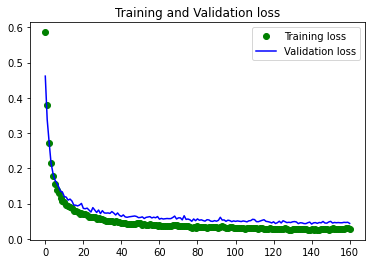

In [44]:
loss = history.history['loss']
val_loss = history.history['val_loss']

#plotting the models performace
epochs = range(len(loss))
plt.plot(epochs, loss, 'go', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

In [45]:
pred = encoder.predict(sales_df)

89/89 [==============================] - 0s 3ms/step


In [46]:
pred[3]

array([1358.2837 , 2247.3948 ,    0.     , 1991.8373 ,  836.21136,
       1857.6409 ,    0.     , 1635.7859 , 1050.2651 ,  872.08606],
      dtype=float32)

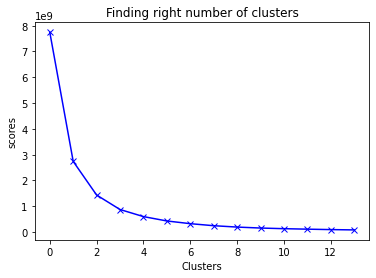

In [47]:
scores = get_scores_from_elbow_method(pred, 15)

plt.plot(scores, 'bx-')
plt.title('Finding right number of clusters')
plt.xlabel('Clusters')
plt.ylabel('scores') 
plt.show()

- Elbow now is clearly at 3

In [48]:
#fit the KMeans using 3 clustures
kmeans = KMeans(3)
kmeans.fit(pred)
labels = kmeans.labels_
y_kmeans = kmeans.fit_predict(sales_df_scaled)

In [49]:
df_cluster_dr = pd.concat([sales_df, pd.DataFrame({'cluster':labels})], axis = 1)
df_cluster_dr.head()

QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER    SALES  MONTH_ID  YEAR_ID  \
0               30      95.70              2.0  2871.00         2     2003   
1               34      81.35              5.0  2765.90         5     2003   
2               41      94.74              2.0  3884.34         7     2003   
3               45      83.26              6.0  3746.70         8     2003   
4               49     100.00             14.0  5205.27        10     2003   

   MSRP  PRODUCTCODE  Australia  Austria  ...  Motorcycles  Planes  Ships  \
0    95            0          0        0  ...            1       0      0   
1    95            0          0        0  ...            1       0      0   
2    95            0          0        0  ...            1       0      0   
3    95            0          0        0  ...            1       0      0   
4    95            0          0        0  ...            1       0      0   

   Trains  Trucks and Buses  Vintage Cars  Large  Medium  Small  cluster  
0       0                 0             0      0       0      1        2  
1       0                 0             0      0       0      1        2  
2       0                 0             0      0       1      0        0  
3       0                 0             0      0       1      0        0  
4       0                 0             0      0       1      0        0  

[5 rows x 38 columns]

In [50]:
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_centers = pd.DataFrame(data = cluster_centers, columns = [sales_df.columns])
cluster_centers

QUANTITYORDERED  PRICEEACH ORDERLINENUMBER        SALES  MONTH_ID  \
0       38.189179  93.058273        5.560099  4182.762123  6.127477   
1       28.539455  67.119800        5.797375  1815.278423  6.286536   
2       36.583888  98.052856        5.512932  5642.368421  6.358560   

       YEAR_ID        MSRP PRODUCTCODE Australia   Austria  ... Classic Cars  \
0  2004.000177  105.270112   55.192548  0.017313 -0.063247  ...     0.046269   
1  2003.960472   80.306408   60.783997  0.025189 -0.021136  ...     0.200297   
2  2003.938683  149.120593   27.690711 -0.077016  0.137314  ...     0.796340   

  Motorcycles    Planes     Ships    Trains Trucks and Buses Vintage Cars  \
0    0.200908  0.257435  0.127621  0.031945         0.126299     0.213983   
1    0.162770  0.250793  0.112004  0.044235         0.052480     0.190650   
2    0.076371  0.095919  0.006120  0.003826        -0.012327     0.000210   

      Large    Medium     Small  
0  0.004893  0.867608  0.110027  
1  0.003758 -0.099781  1.106386  
2  0.267815  0.604814  0.132381  

[3 rows x 37 columns]

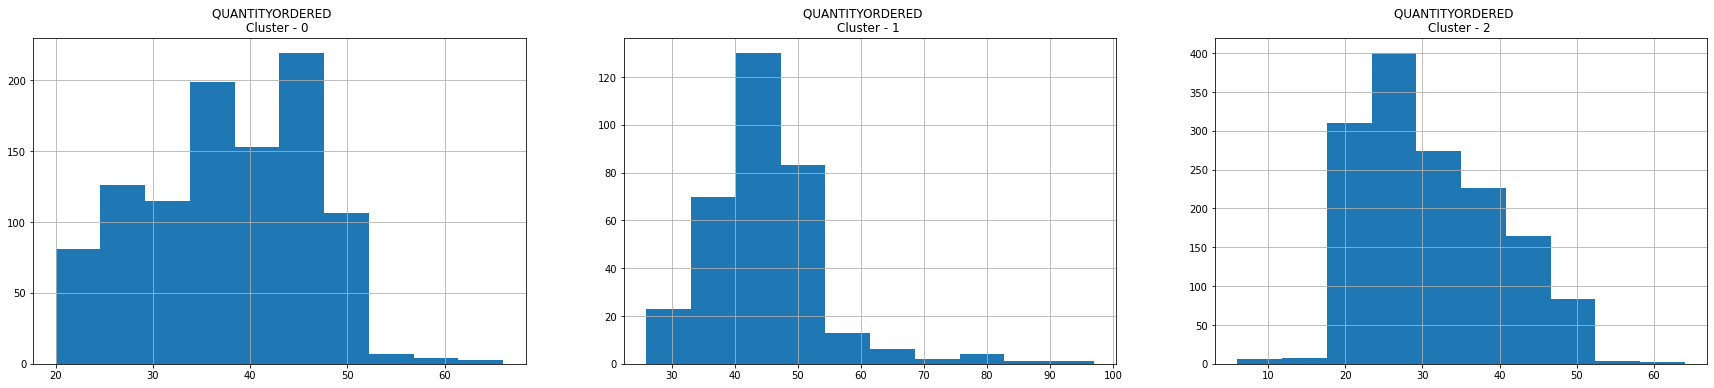

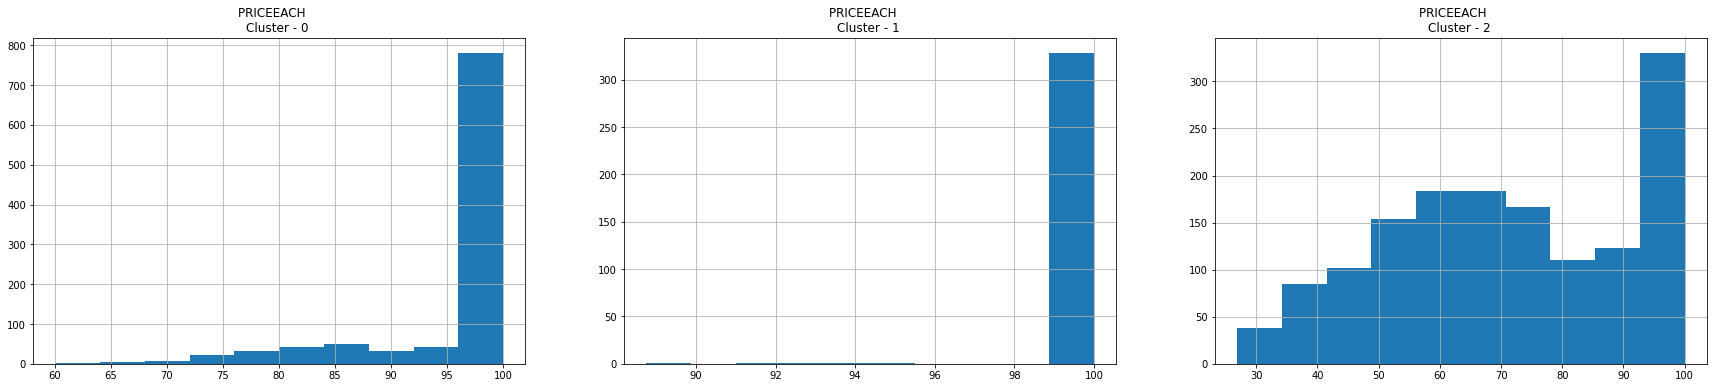

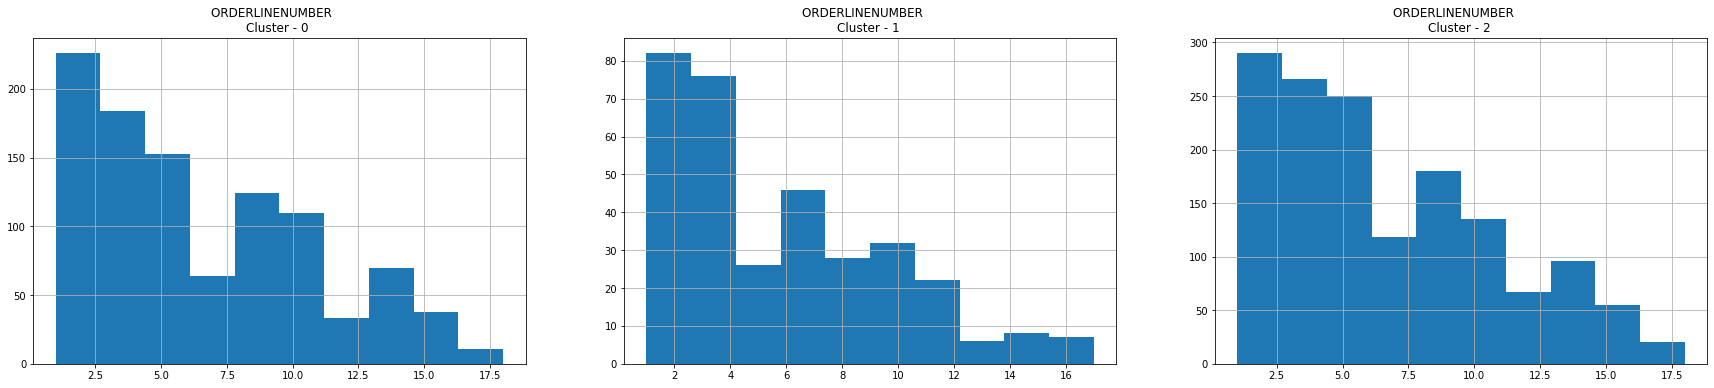

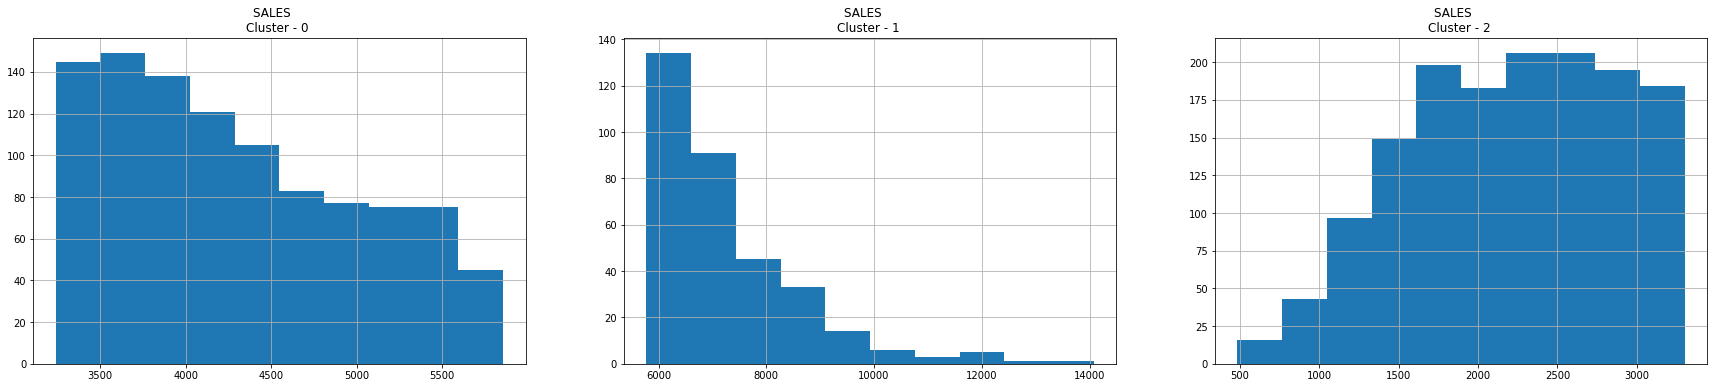

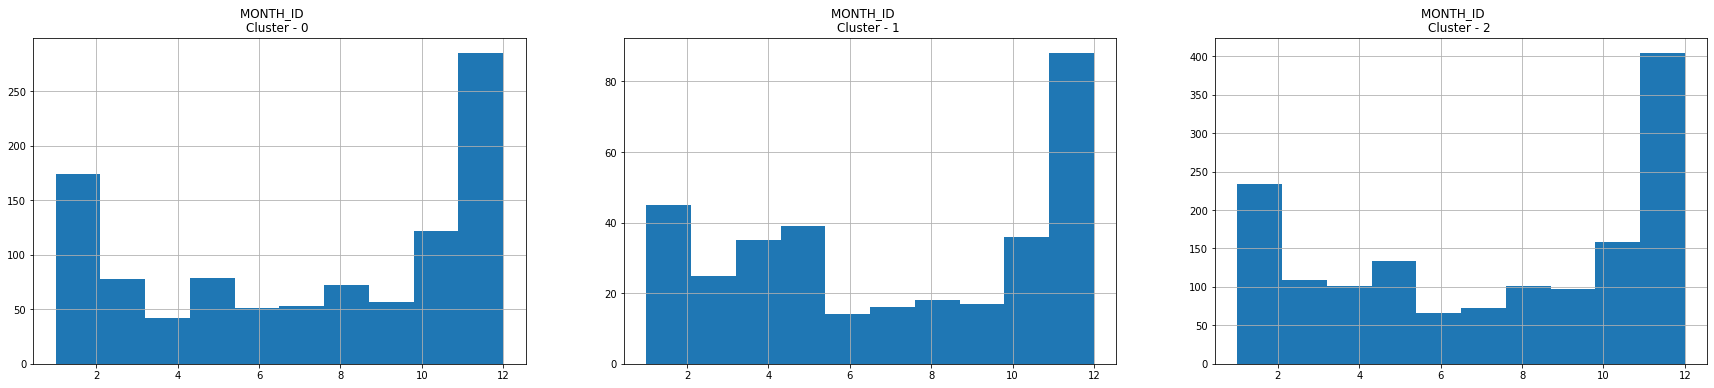

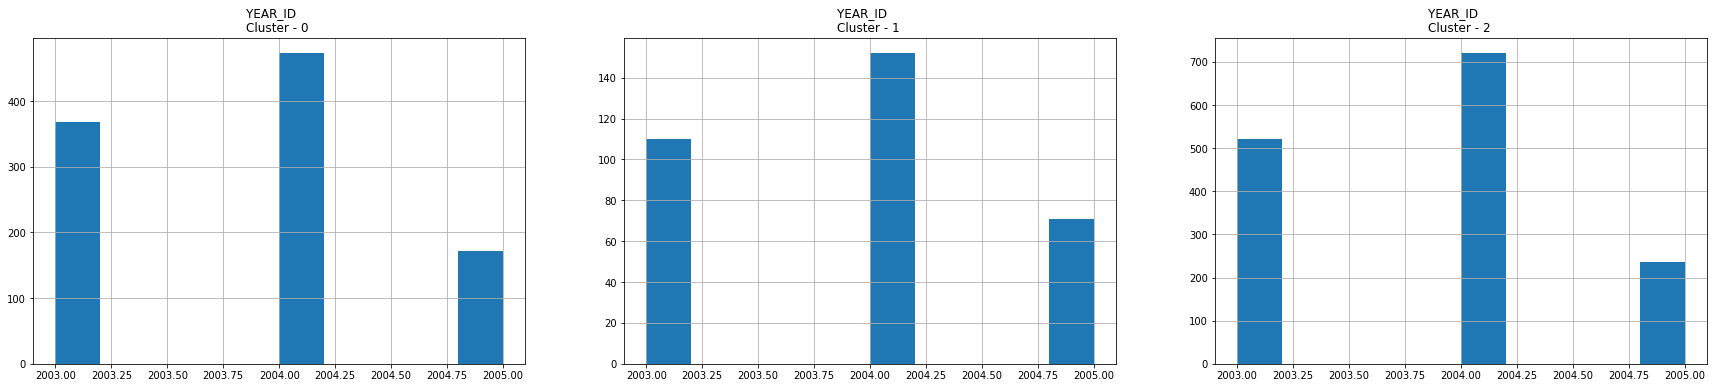

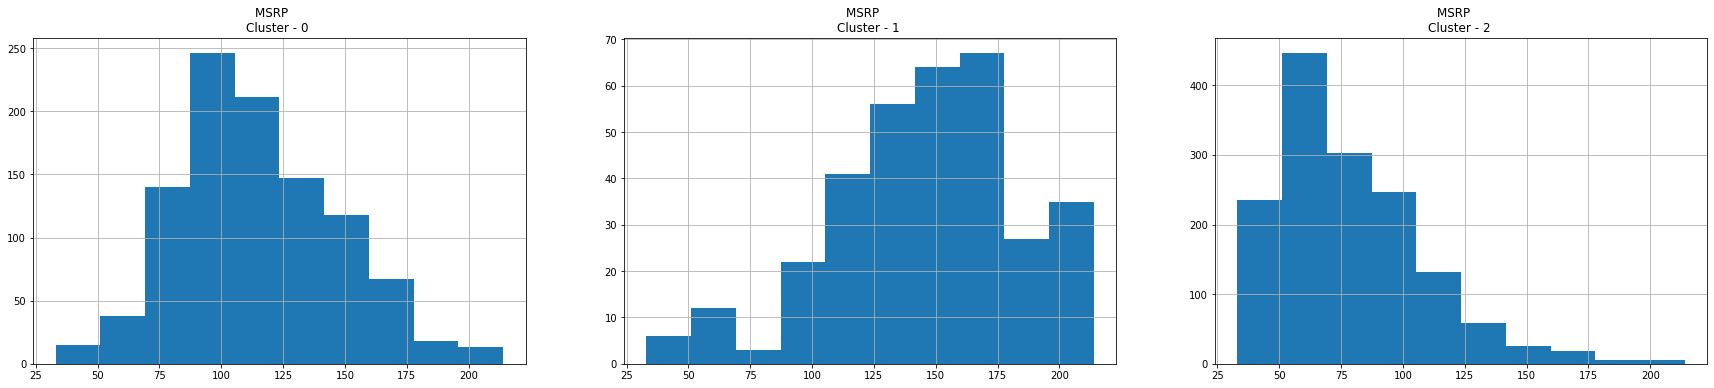

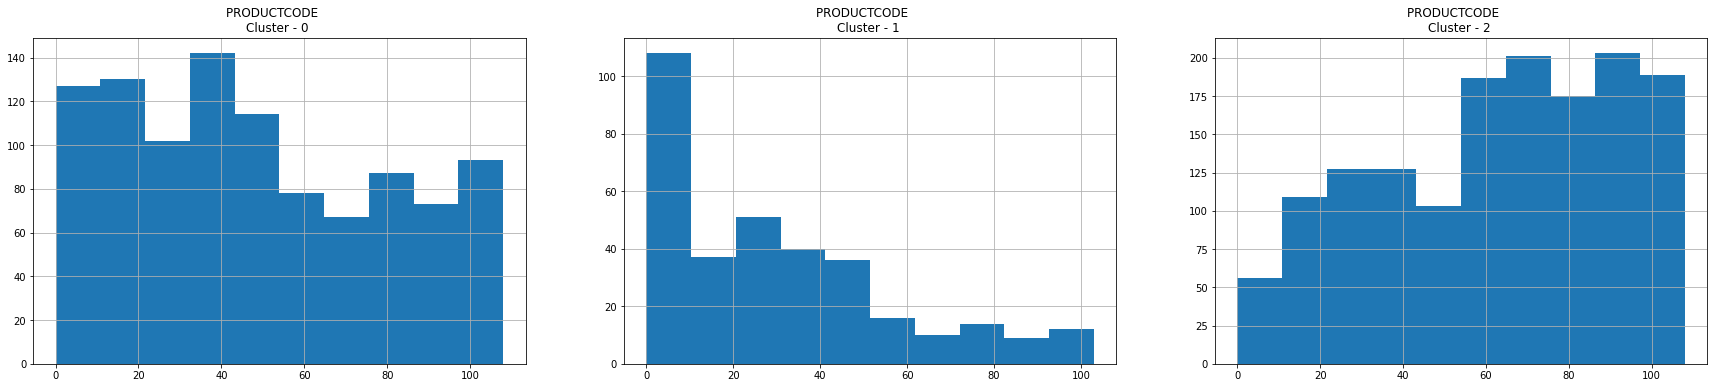

In [51]:
plot_hist_4_clusters(df_cluster_dr,3)

In [52]:
# Reduce the original data to 3 dimension using PCA for visualize the clusters
pca = PCA(n_components = 3)
prin_comp = pca.fit_transform(sales_df_scaled)
pca_df = pd.DataFrame(data = prin_comp, columns = ['pca1', 'pca2', 'pca3'])
pca_df = pd.concat([pca_df, pd.DataFrame({'cluster':labels})], axis = 1)
pca_df.head()

pca1      pca2      pca3  cluster
0 -0.486311 -1.175006  0.935643        2
1 -0.784431 -0.969456  1.283875        2
2  1.431671  0.166182  0.131436        0
3  1.288502 -0.204054 -0.672469        0
4  1.976150 -0.107032 -1.141613        0

In [53]:
# Visualize clusters using 3D-Scatterplot
fig = px.scatter_3d(pca_df, x = 'pca1', y = 'pca2', z = 'pca3',
              color='cluster', symbol = 'cluster', size_max = 10, opacity = 0.7)

fig.update_layout(margin = dict(l = 0, r = 0, b = 0, t = 0), legend = legend)
